### 0.0. Dependencies and Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import math 
import rfpimp

In [2]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [3]:
print(retail_areas.dtypes)

date                                                       object
id                                                        float64
events                                                    float64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local Footprint Name                                       object
Region                                                     object
Base Score                                                float64
Retail Footprint Score                                    float64
Residential Population (Weighted Catchment)               float64
Spend Per Head (Residential)                              float64
Sparsity                                                   object
Longitude                                                 float64
Latitude                                                  float64
Tourism Sc

In [4]:
print("Number of unique Local_Footprint_Centre_ID:", retail_areas['Local_Footprint_Centre_ID'].nunique())
print("Total number of rows:", len(retail_areas))

Number of unique Local_Footprint_Centre_ID: 1207
Total number of rows: 437686


In [5]:
unique_days = retail_areas.loc[retail_areas['mean_wind'].isna(), 'date'].unique()
unique_days_sorted = sorted(unique_days)
print("Unique days with missing mean_wind:", unique_days_sorted)

Unique days with missing mean_wind: ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-25', '2024-02-09', '2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-23', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-07-05', '2024-07-06', '2024-07-07', '2024-08-05', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-28', '2024-08-29', '2024-08-30', '2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-11', '2024-10-07', '2024-10-12', '2024-10-13', '2024-10-30

### 1.1. Model Prep

#### 1.1.1. Check for linear relationships

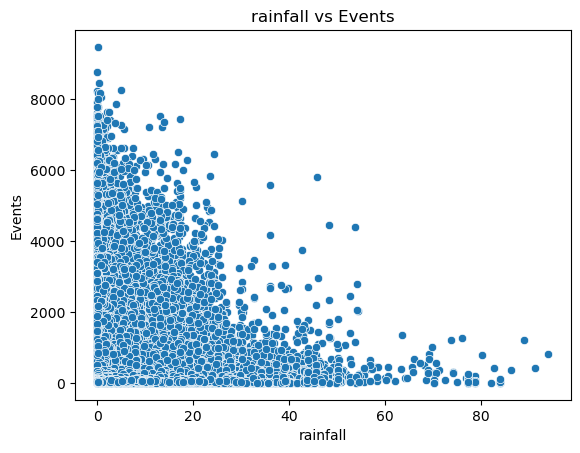

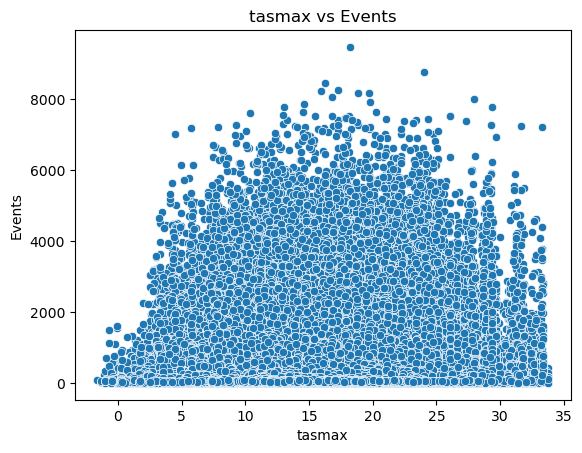

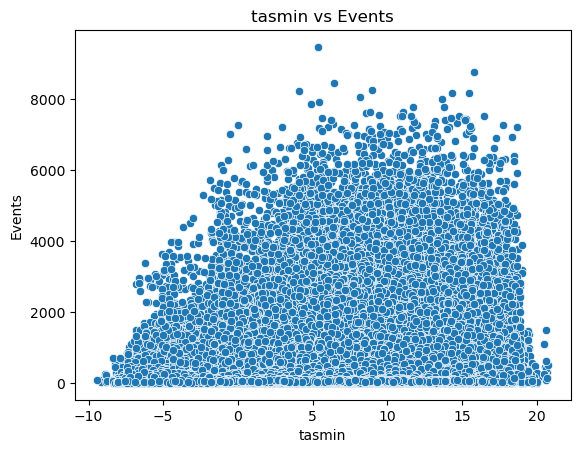

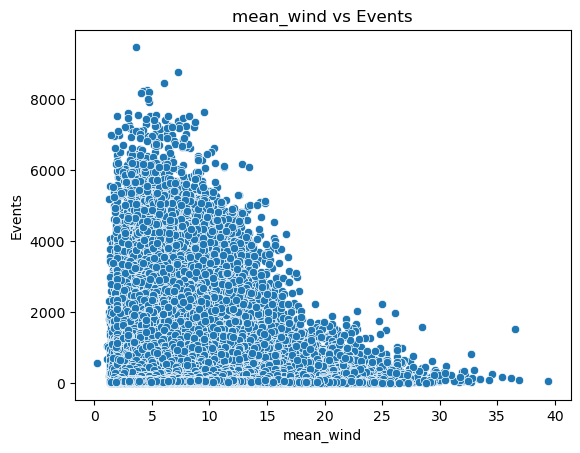

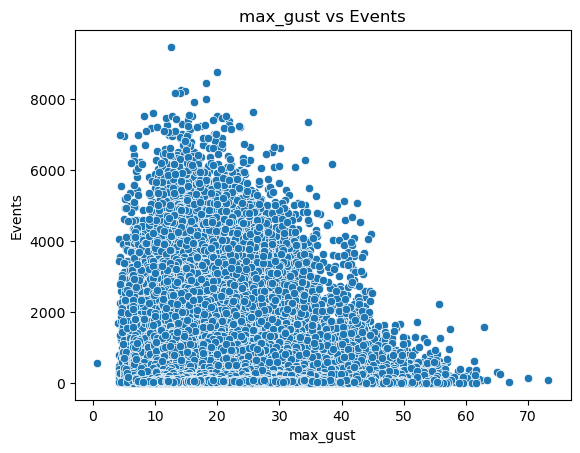

In [6]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.scatterplot(x=var, y='events', data=retail_areas)
    plt.title(f'{var} vs Events')
    plt.xlabel(var)
    plt.ylabel('Events')
    plt.show()

#### 1.1.2. Variable encoding

In [7]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# drop unnecessary columns
df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name', 'Seasonality_Class_Name'], axis=1)

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score       680
rainfall           3976
tasmax             3976
tasmin             3976
mean_wind        132578
max_gust         132578
dtype: int64
Rows with at least one missing value: 135831
Total rows before drop: 437686
Total rows after drop: 301855


### 2.1. General Model

#### 2.1.1. Most basic

In [8]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'weekend',
    'holiday',
    ] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [9]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1175
2024-01-16    1179
2024-01-17    1172
2024-01-18    1178
2024-01-19    1180
              ... 
2024-11-20    1183
2024-11-25    1184
2024-11-26    1181
2024-11-27    1186
2024-12-02    1183
Name: id, Length: 255, dtype: int64


In [10]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(241484, 6)
(241484,)
(60371, 6)
(60371,)
True
True


Hyperparameters:

In [11]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=2; total time=  11.4s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  12.1s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  12.6s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  13.0s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  12.8s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  13.1s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  12.9s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  13.0s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  13.5s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  14.1s
[CV] END .................max_depth=10, min_samples_split=10; total time=  13.3s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  14.1s
[CV] END ..................m

Implement random forest:

In [12]:
rf_final = RandomForestRegressor(**clf.best_params_, 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,40
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.8059616695971891
R² on the testing data:
0.8047217331231161


In [14]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
276.00202024812813
RMSE on the testing data:
282.42710768959813


Cross-validate model performance:

In [15]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.8070 ± 0.0011
Mean Train RMSE: 275.2352 ± 0.5515
Mean Test R²: 0.7955 ± 0.0046
Mean Test RMSE: 283.3034 ± 2.2917


Feature importance:

                                             Importance
Feature                                                
Residential Population (Weighted Catchment)    1.579562
season_Winter                                  0.036294
season_Spring                                  0.033532
season_Summer                                  0.013138
weekend                                        0.011500
holiday                                        0.001088


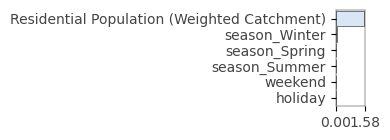

In [16]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 2.1.2. Add CACI scores

Train/test:

In [17]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [18]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1175
2024-01-16    1179
2024-01-17    1172
2024-01-18    1178
2024-01-19    1180
              ... 
2024-11-20    1183
2024-11-25    1184
2024-11-26    1181
2024-11-27    1186
2024-12-02    1183
Name: id, Length: 255, dtype: int64


In [19]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(241484, 9)
(241484,)
(60371, 9)
(60371,)
True
True


Hyperparameters:

In [20]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time=  19.8s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  20.3s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  19.8s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  19.9s
[CV] END .................max_depth=10, min_samples_split=10; total time=  19.7s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  20.3s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  20.5s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  20.4s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  20.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  20.7s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  20.3s
[CV] END ..................max_depth=10, min_sa

Implement random forest:

In [21]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9419959254693462
R² on the testing data:
0.9372226224991707


In [23]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
150.9029560827507
RMSE on the testing data:
160.13306162512416


Cross-validate model performance:

In [24]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9426 ± 0.0003
Mean Train RMSE: 150.0538 ± 0.2764
Mean Test R²: 0.9353 ± 0.0013
Mean Test RMSE: 159.3801 ± 1.0760


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.131534
Retail Footprint Score                         0.691646
Tourism Score                                  0.529633
Residential Population (Weighted Catchment)    0.424833
season_Winter                                  0.038524
season_Spring                                  0.035065
weekend                                        0.011966
season_Summer                                  0.006330
holiday                                        0.000363


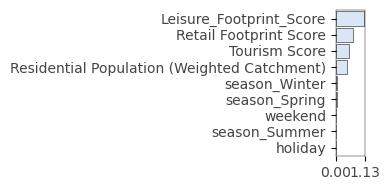

In [25]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 2.1.3. Add weather

Train/test:

In [26]:
# define target and features
target = 'events'
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars + [col for col in df_model.columns if col.startswith('season_')]

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [27]:
print(features)

['Residential Population (Weighted Catchment)', 'Tourism Score', 'Retail Footprint Score', 'Leisure_Footprint_Score', 'weekend', 'holiday', 'rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust', 'season_Spring', 'season_Summer', 'season_Winter']


In [28]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(241484, 14)
(241484,)
(60371, 14)
(60371,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.5min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.5min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.5min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.5min
[CV] END ..................m

Implement random forest:

In [ ]:
rf_general_weather = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_general_weather.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_general_weather.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_general_weather.score(X=test_x, y=test_y))

R² on the training data:
0.9714401496366879
R² on the testing data:
0.9344921401195806


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_general_weather.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_general_weather.predict(test_x)))

RMSE on the training data:
105.88793045894269
RMSE on the testing data:
163.57846487872388


Cross-validated performance:

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_general_weather,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9761 ± 0.0001
Mean Train RMSE: 96.9181 ± 0.1634
Mean Test R²: 0.9324 ± 0.0013
Mean Test RMSE: 162.8306 ± 1.0929


Feature importance:

                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.172770
Retail Footprint Score                         0.810032
Tourism Score                                  0.612212
Residential Population (Weighted Catchment)    0.441248
season_Winter                                  0.039714
season_Spring                                  0.037924
weekend                                        0.012747
tasmax                                         0.006862
season_Summer                                  0.005619
tasmin                                         0.003089
mean_wind                                      0.000954
rainfall                                       0.000869
max_gust                                       0.000794
holiday                                        0.000257


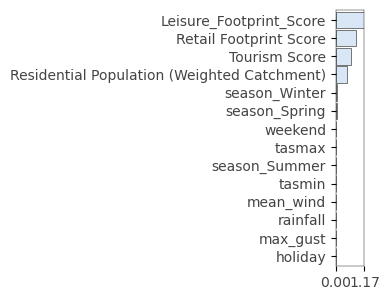

In [ ]:
imp = rfpimp.importances(rf_general_weather, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 2.1.4. Add retail type

Get retail type dummies:

In [ ]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# drop unnecessary columns
df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name', 'Seasonality_Class_Name'], axis=1)

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_') or col.startswith('groupName_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(241484, 21)
(241484,)
(60371, 21)
(60371,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.6min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.7min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.7min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.7min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.7min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.7min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.7min
[CV] END .................ma

Implement random forest:

In [ ]:
rf_retail = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_retail.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_retail.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_retail.score(X=test_x, y=test_y))

R² on the training data:
0.9712529680814744
R² on the testing data:
0.9350576683784715


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_retail.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_retail.predict(test_x)))

RMSE on the training data:
106.23435905851343
RMSE on the testing data:
162.87084928400242


Cross-validated performance:

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained rf_retail model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_retail,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_r2 = np.mean(cv_results['test_r2'])
std_r2 = np.std(cv_results['test_r2'])

mean_rmse = -np.mean(cv_results['test_rmse'])  # negate because it's negative by default
std_rmse = np.std(cv_results['test_rmse'])

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9714 ± 0.0002
Mean Train RMSE: 106.0123 ± 0.3733
Mean Test R²: 0.9332 ± 0.0013
Mean Test RMSE: 161.9162 ± 1.1022


Feature importance:

                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.162484
Retail Footprint Score                                0.448619
Tourism Score                                         0.389093
groupName_Indie high streets                          0.348246
Residential Population (Weighted Catchment)           0.137779
season_Winter                                         0.045407
groupName_Secondary retail parks and shopping c...    0.032614
season_Spring                                         0.026948
groupName_Local urban convenience centres             0.021115
weekend                                               0.012460
tasmax                                                0.004815
groupName_Mass and value high streets                 0.003102
season_Summer                                         0.003016
max_gust                                              0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


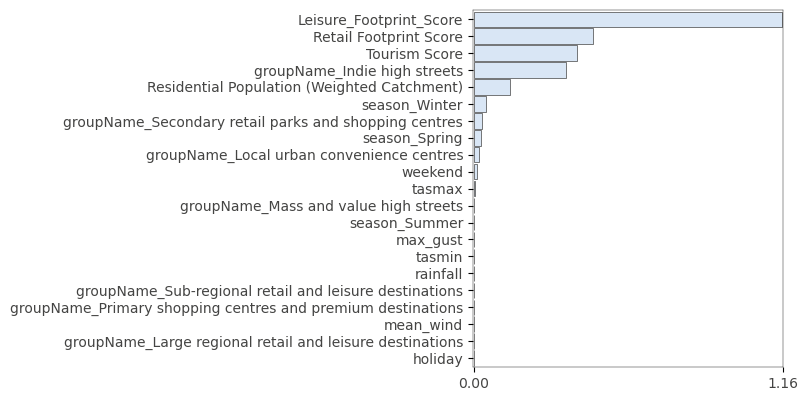

In [ ]:
imp = rfpimp.importances(rf_retail, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Partial dependence plot:

NameError: name 'PartialDependenceDisplay' is not defined

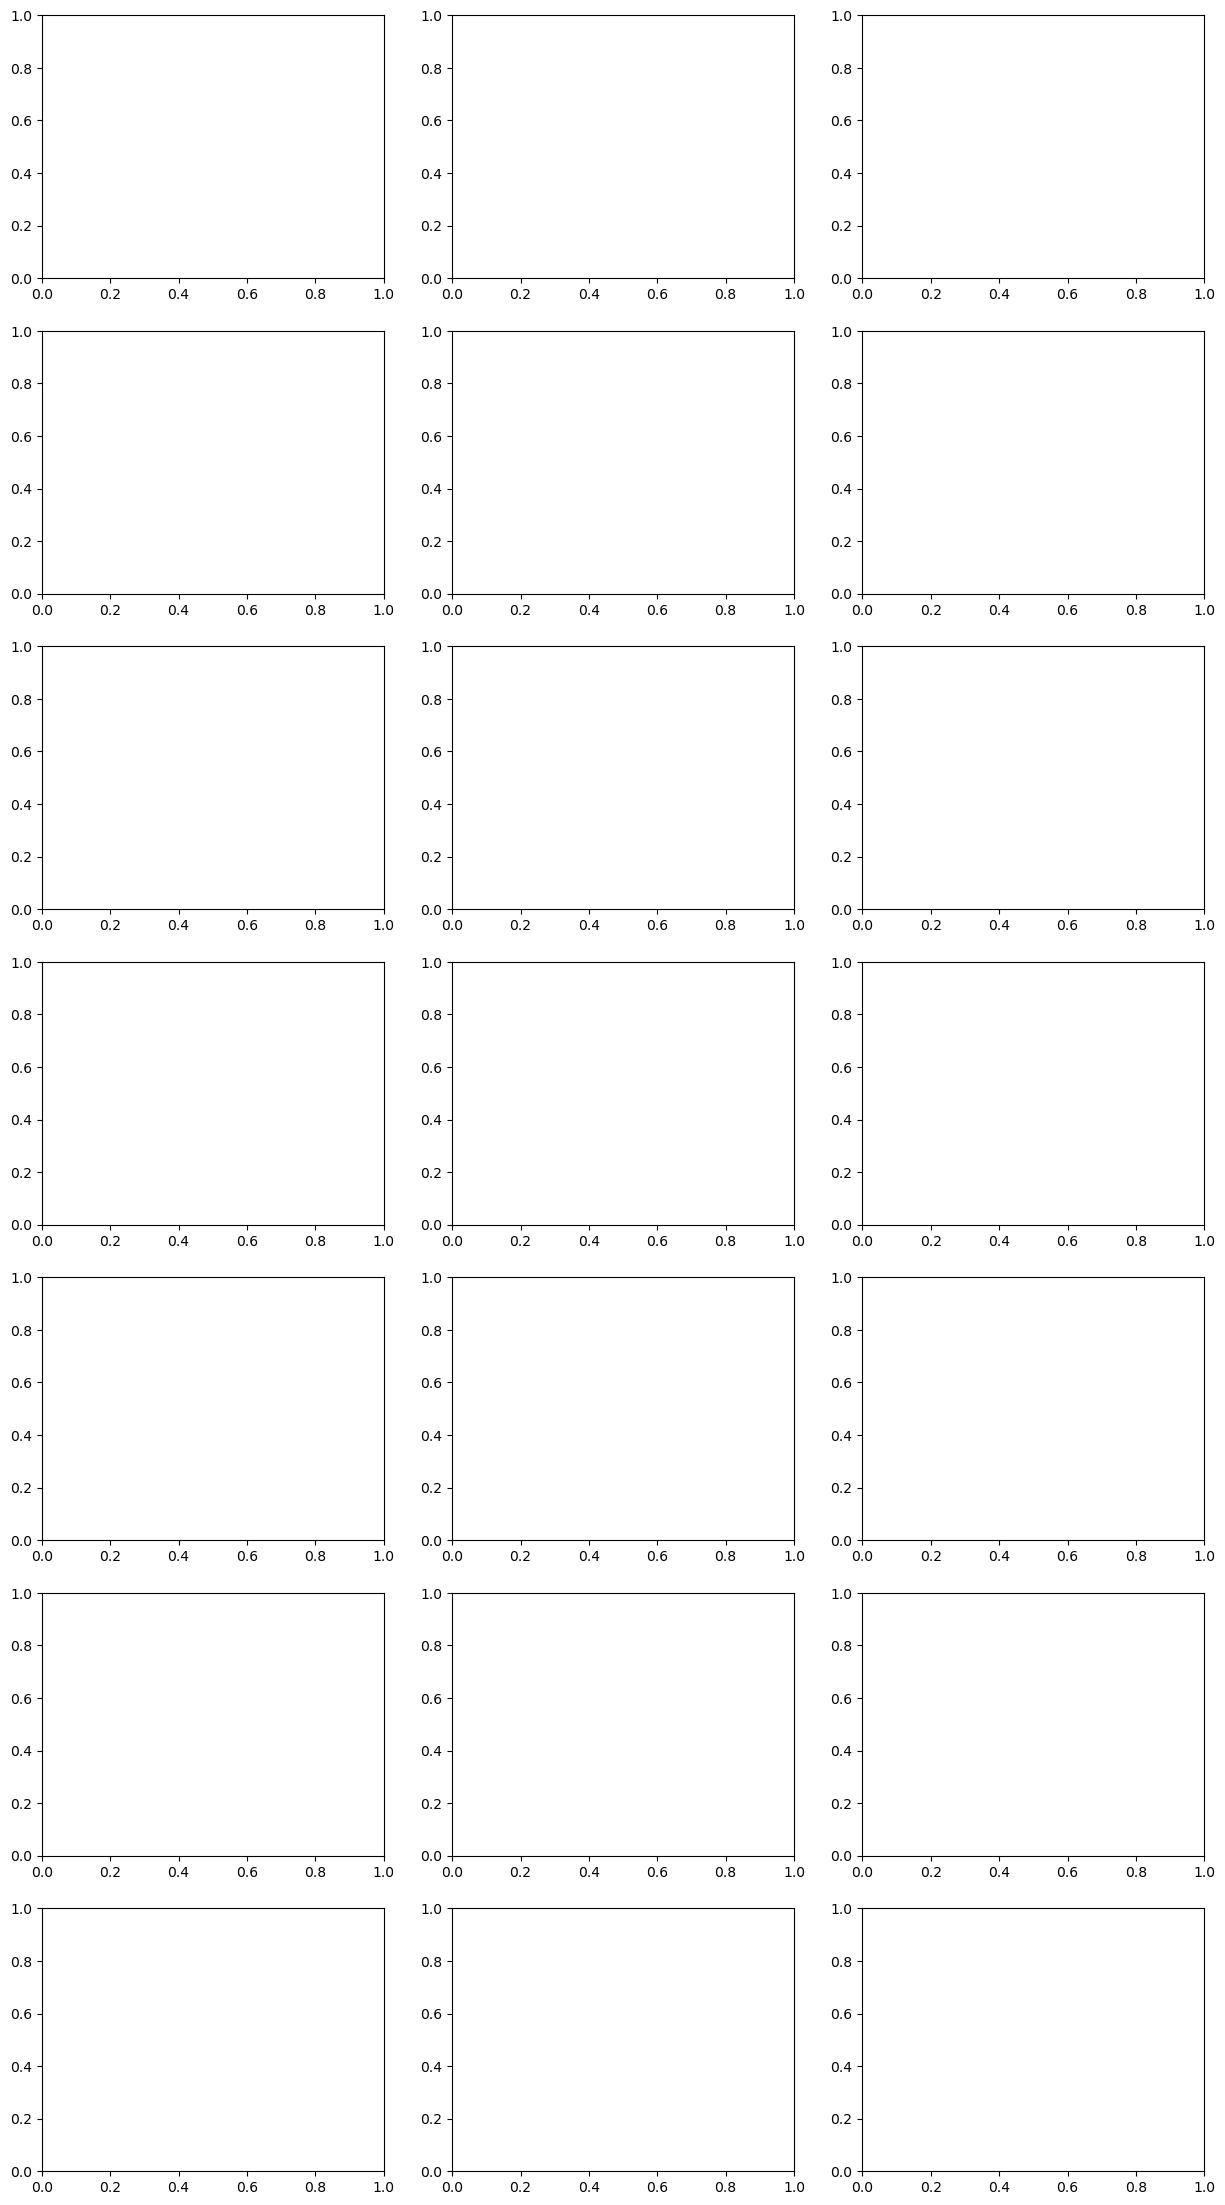

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# plot partial dependence for all features in train_x
features = train_x.columns.tolist() 

# create grid layout
n_features = len(features)
n_cols = 3
n_rows = -(-n_features // n_cols)  # ceiling division

fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
ax = ax.flatten()

# plot
PartialDependenceDisplay.from_estimator(
    rf_retail,
    train_x,
    features=features,
    ax=ax[:n_features]  # ensure ax isn't longer than the number of features
)

plt.tight_layout()
plt.show()

### 2.2. Model per retail type

#### 2.2.1. Without weather

In [ ]:
# copy to avoid modifying original
df_model2 = retail_areas.copy()

df_model2 = df_model2.drop(['Minor_Class_Name', 'Major_Class_Name'], axis=1)

# One-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
            #'supergroupName', 'groupName']
df_model2 = pd.get_dummies(df_model2, columns=cat_vars, drop_first=True)

print(df_model2.isnull().sum())
num_rows_with_missing = df_model2.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model2)}")
df_model2 = df_model2.dropna()
print(f"Total rows after drop: {len(df_model2)}")

date                               0
id                                 0
events                             0
weekend                            0
holiday                            0
                                  ..
Region_South East                  0
Region_South West                  0
Region_Wales                       0
Region_West Midlands               0
Region_Yorkshire and The Humber    0
Length: 71, dtype: int64
Rows with at least one missing value: 164022
Total rows before drop: 524131
Total rows after drop: 360109


Model:

In [ ]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + [col for col in df_model2.columns if col.startswith('season_')]


Group: District urban service centres
R² (train): 0.962 | R² (test): 0.958
Feature Importances:
Leisure_Footprint_Score                        0.578
Retail Footprint Score                         0.208
Tourism Score                                  0.137
Residential Population (Weighted Catchment)    0.042
season_Winter                                  0.013
season_Spring                                  0.011
weekend                                        0.007
season_Summer                                  0.004
holiday                                        0.002
dtype: float64

Group: Indie high streets
R² (train): 0.871 | R² (test): 0.853
Feature Importances:
Leisure_Footprint_Score                        0.491
Tourism Score                                  0.230
Retail Footprint Score                         0.122
Residential Population (Weighted Catchment)    0.083
season_Winter                                  0.025
season_Spring                                  0.019
weekend 

Add calibration:

In [ ]:
# loop over groups
for name, group_data in df_model2.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=-1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))




Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.957
R² (train): 0.962 | R² (test): 0.958
Feature Importances:
Leisure_Footprint_Score                        0.578
Retail Footprint Score                         0.204
Tourism Score                                  0.141
Residential Population (Weighted Catchment)    0.041
season_Winter                                  0.013
season_Spring                                  0.011
weekend                                        0.007
season_Summer                                  0.004
holiday                                        0.002
dtype: float64

Group: Indie high streets
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.857
R² (train): 0.871 | R² (test): 0.853
Feature Importances:
Leisure_Footprint_Score                        0.493
Tourism Score                                  0.229
Retail Footprint Score                         0.121

#### 2.2.2. With weather

Calibrated and cross-validated:

In [ ]:
# loop over groups
for name, group_data in df_model2.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model on full group data (not just train_x/y)
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    )

    # repeated k-fold cross-validation
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_results = cross_validate(
        model,
        group_data[features], group_data[target],
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize metrics
    mean_train_r2 = np.mean(cv_results['train_r2'])
    std_train_r2 = np.std(cv_results['train_r2'])

    mean_test_r2 = np.mean(cv_results['test_r2'])
    std_test_r2 = np.std(cv_results['test_r2'])

    mean_train_rmse = -np.mean(cv_results['train_rmse'])
    std_train_rmse = np.std(cv_results['train_rmse'])

    mean_test_rmse = -np.mean(cv_results['test_rmse'])
    std_test_rmse = np.std(cv_results['test_rmse'])

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {mean_train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {mean_train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {mean_test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {mean_test_rmse:.3f} ± {std_test_rmse:.3f}")

    # fit final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)

    print("Feature Importances:")
    print(importances.round(3))

Partial dependence plots:

In [ ]:
for name, group_data in df_model2.groupby('groupName'):
    if len(group_data) < 30:
        continue  # skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # handle missing values (robustness)
    X = X.fillna(X.median())

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

NameError: name 'df_model' is not defined

#### later

Leisure footprint?
rail/tube--- specifically for london?

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns 
     if col.startswith('season_')]

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

NameError: name 'df_model' is not defined

In [ ]:
print(features)

['Residential Population (Weighted Catchment)', 'Tourism Score', 'Retail Footprint Score', 'Leisure_Footprint_Score', 'weekend', 'holiday', 'season_Spring', 'season_Summer', 'season_Winter', 'groupName_Indie high streets', 'groupName_Large regional retail and leisure destinations', 'groupName_Local urban convenience centres', 'groupName_Mass and value high streets', 'groupName_Primary shopping centres and premium destinations', 'groupName_Secondary retail parks and shopping centres', 'groupName_Sub-regional retail and leisure destinations']


In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 9)
(289303,)
(72326, 9)
(72326,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time=  55.5s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  56.0s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  56.0s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  59.5s
[CV] END .................max_depth=10, min_samples_split=10; total time=  56.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  57.3s
[CV] END .................max_depth=10, min_samples_split=10; total time=  57.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  58.3s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  58.5s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  58.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  59.1s
[CV] END ..................max_depth=10, min_sa

Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9439422815171746
R² on the testing data:
0.939016025757529


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,6
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9372260532518457
R² on the testing data:
0.9307798770000343


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
156.48655217032308
RMSE on the testing data:
164.52627186415876


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.162253
Tourism Score                                  0.455117
Retail Footprint Score                         0.366579
Residential Population (Weighted Catchment)    0.246387
season_Winter                                  0.034506
season_Spring                                  0.031154
weekend                                        0.014401
season_Summer                                  0.007182
holiday                                        0.001427


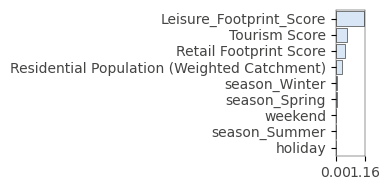

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.4. With weather

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 11)
(289303,)
(72326, 11)
(72326,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_sa

Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9908713861202267
R² on the testing data:
0.9360868105828182


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9714194435466766
R² on the testing data:
0.9377986303177244


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
106.26690547030053
RMSE on the testing data:
158.10112148035526


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.156042
Tourism Score                                  0.450586
Retail Footprint Score                         0.322407
Residential Population (Weighted Catchment)    0.213414
weekend                                        0.013824
tasmax                                         0.009230
tasmin                                         0.005394
mean_wind                                      0.003617
max_gust                                       0.002520
rainfall                                       0.000883
holiday                                        0.000743


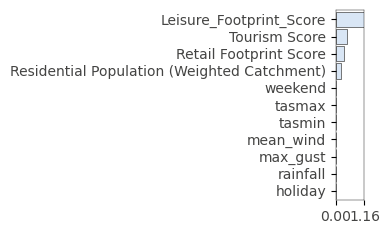

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### Add typology

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_') or col.startswith('groupName_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 21)
(289303,)
(72326, 21)
(72326,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_sa

Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9908930224879019
R² on the testing data:
0.9360937384607905


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9714194435466766
R² on the testing data:
0.9377986303177244


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
104.87896677948886
RMSE on the testing data:
158.03132282628775


                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.359512
Tourism Score                                         0.464085
groupName_Indie high streets                          0.280403
Retail Footprint Score                                0.257832
Residential Population (Weighted Catchment)           0.143669
groupName_Local urban convenience centres             0.069759
season_Winter                                         0.035265
season_Spring                                         0.022191
weekend                                               0.021959
groupName_Secondary retail parks and shopping c...    0.008737
tasmax                                                0.005488
groupName_Primary shopping centres and premium ...    0.003662
season_Summer                                         0.003643
tasmin                                                0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


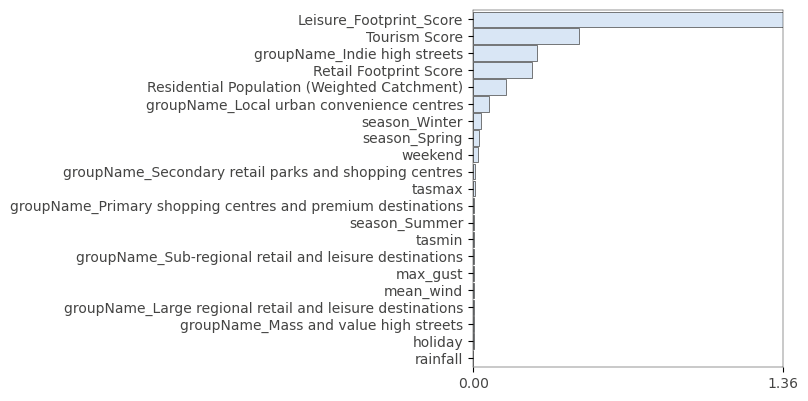

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()